In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Créer un dossier pour les fichiers nettoyés
os.makedirs("data/processed", exist_ok=True)

# Charger les fichiers
events = pd.read_csv("events.csv")
category_tree = pd.read_csv("category_tree.csv")
item_part1 = pd.read_csv("item_properties_part1.csv")
item_part2 = pd.read_csv("item_properties_part2.csv")


In [ ]:
Exploration initiale

In [2]:
def explore(df, name):
    print(f"--- {name} ---")
    print(df.shape)
    print(df.info())
    print("Valeurs manquantes:\n", df.isna().sum())
    print("Doublons:", df.duplicated().sum())
    print("\n")

explore(events, "Events")
explore(category_tree, "Category Tree")
explore(item_part1, "Item Properties Part 1")
explore(item_part2, "Item Properties Part 2")


--- Events ---
(2756101, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB
None
Valeurs manquantes:
 timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2733644
dtype: int64
Doublons: 460


--- Category Tree ---
(1669, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   categoryid  1669 non-null   int64  
 1   parentid    1644 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 26.2 KB
None
Valeurs manquantes:
 categoryid     0
parentid      25
dtype: 

In [ ]:
## 3. Nettoyage et préparation des données

In [3]:
events['date'] = pd.to_datetime(events['timestamp'], unit='ms')
events['hour'] = events['date'].dt.hour

# A/B Testing: Split visiteurs uniques 50/50
unique_visitors = events['visitorid'].unique()
np.random.shuffle(unique_visitors)
split = len(unique_visitors) // 2
group_A = unique_visitors[:split]
group_B = unique_visitors[split:]
events['group'] = np.where(events['visitorid'].isin(group_A), 'A', 'B')

# Sauvegarde
events.to_csv("data/processed/events_clean.csv", index=False)


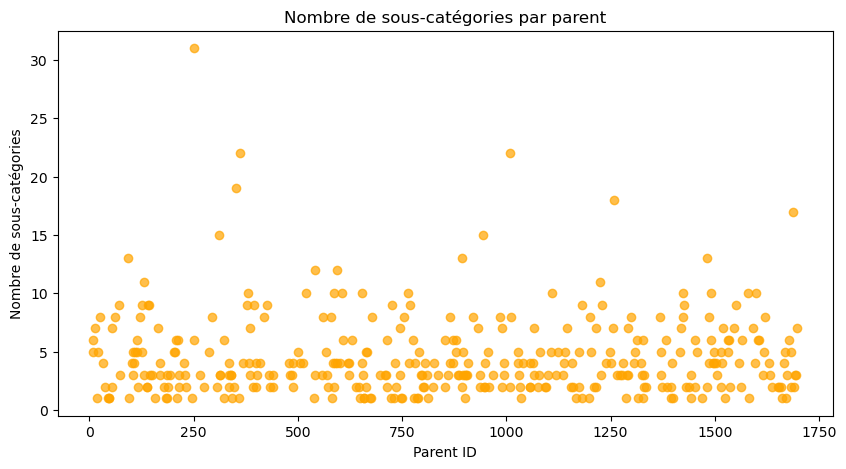

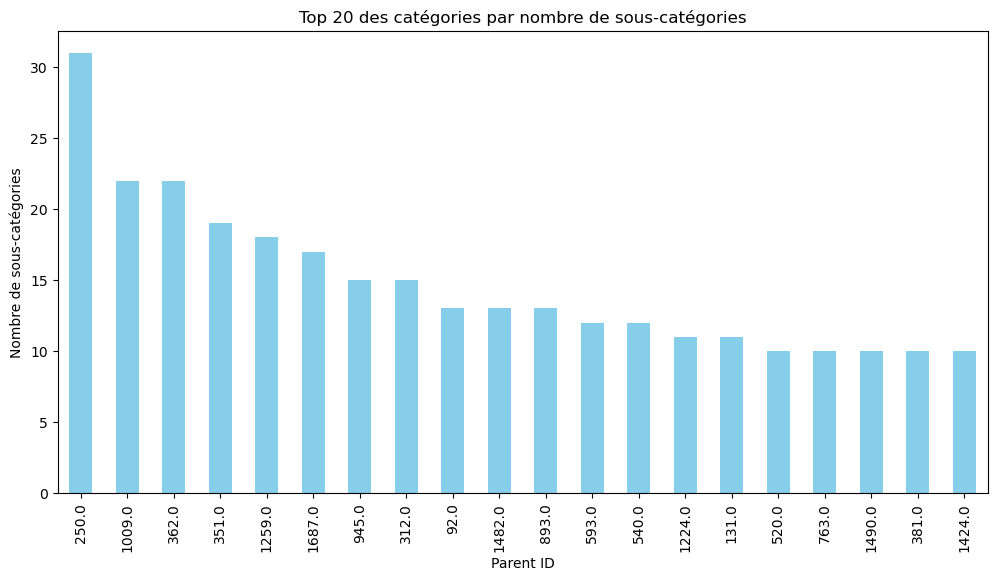

In [4]:
subcat_count = category_tree.groupby('parentid')['categoryid'].count()

# Scatter plot
plt.figure(figsize=(10,5))
plt.scatter(subcat_count.index, subcat_count.values, color='orange', alpha=0.7)
plt.title("Nombre de sous-catégories par parent")
plt.xlabel("Parent ID")
plt.ylabel("Nombre de sous-catégories")
plt.show()

# Top 20 parents avec plus de sous-catégories
plt.figure(figsize=(12,6))
subcat_count.sort_values(ascending=False).head(20).plot(kind='bar', color='skyblue')
plt.title("Top 20 des catégories par nombre de sous-catégories")
plt.xlabel("Parent ID")
plt.ylabel("Nombre de sous-catégories")
plt.show()

# Sauvegarde
category_tree.to_csv("data/processed/category_tree_clean.csv", index=False)


In [5]:
item_properties = pd.concat([item_part1, item_part2], ignore_index=True)

# Par exemple, convertir 'value' en int si possible
item_properties['value'] = pd.to_numeric(item_properties['value'], errors='coerce')
item_properties.dropna(subset=['value'], inplace=True)

# Vérification
print(item_properties.info())

# Sauvegarde
item_properties.to_csv("data/processed/item_properties_clean.csv", index=False)


<class 'pandas.core.frame.DataFrame'>
Index: 10631047 entries, 0 to 20275900
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  int64  
 1   itemid     int64  
 2   property   object 
 3   value      float64
dtypes: float64(1), int64(2), object(1)
memory usage: 405.5+ MB
None


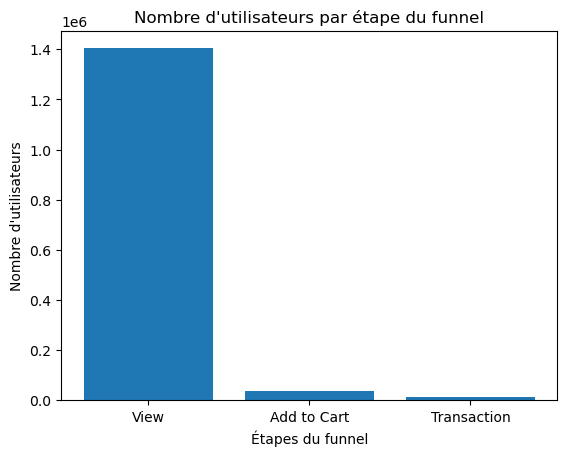

In [6]:
funnel_labels = ["View", "Add to Cart", "Transaction"]
funnel_users = [events[events['event']=="view"]['visitorid'].nunique(),
                events[events['event']=="addtocart"]['visitorid'].nunique(),
                events[events['event']=="transaction"]['visitorid'].nunique()]

plt.figure()
plt.bar(funnel_labels, funnel_users)
plt.title("Nombre d'utilisateurs par étape du funnel")
plt.xlabel("Étapes du funnel")
plt.ylabel("Nombre d'utilisateurs")
plt.show()


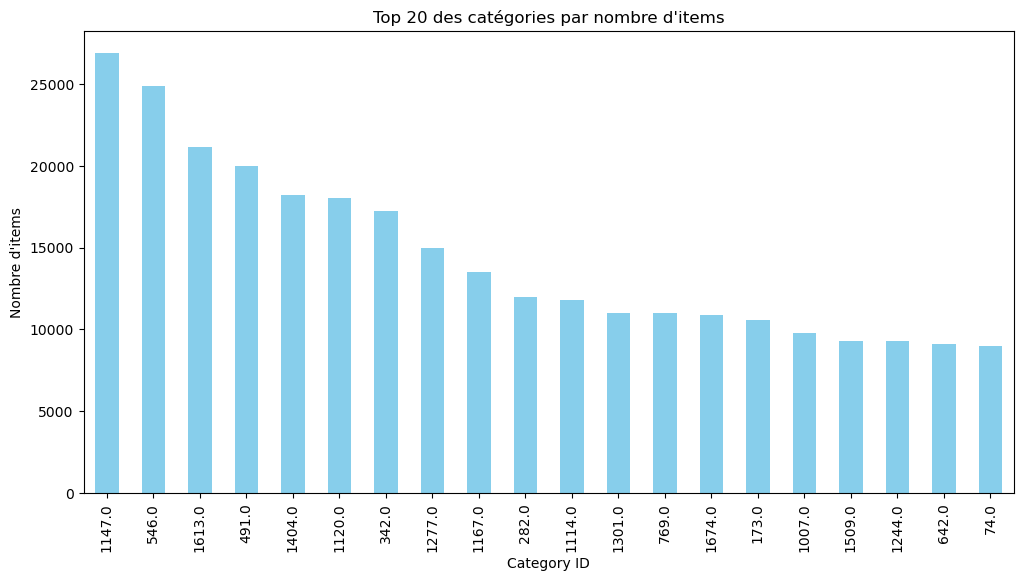

In [7]:
category_counts = item_properties[item_properties['property']=='categoryid']['value'].value_counts()

plt.figure(figsize=(12,6))
category_counts.head(20).plot(kind='bar', color='skyblue')
plt.title("Top 20 des catégories par nombre d'items")
plt.xlabel("Category ID")
plt.ylabel("Nombre d'items")
plt.show()


itemid
461686    133
119736     97
213834     92
312728     46
7943       46
445351     45
48030      41
420960     38
248455     38
17478      37
409804     35
320130     33
416017     32
46156      31
369447     31
268883     29
334401     28
257040     27
441852     27
9877       25
Name: count, dtype: int64


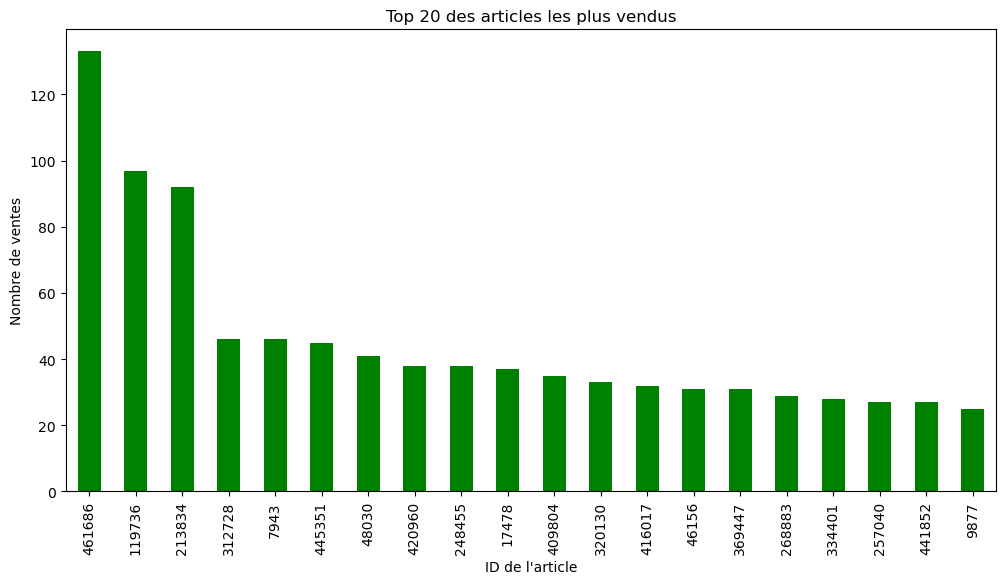

In [8]:
# Filtrer seulement les transactions
transactions = events[events['event'] == 'transaction']

# Compter le nombre de transactions par item
top_items = transactions['itemid'].value_counts().head(20)  # Top 20 articles

# Afficher
print(top_items)

# Visualisation
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
top_items.plot(kind='bar', color='green')
plt.title("Top 20 des articles les plus vendus")
plt.xlabel("ID de l'article")
plt.ylabel("Nombre de ventes")
plt.show()


In [15]:
# Filtrer les transactions et créer une copie
transactions = events[events['event'] == 'transaction'].copy()

# Conversion timestamp en datetime
transactions['datetime'] = pd.to_datetime(transactions['timestamp'], unit='ms')

# Extraire le jour de la semaine et l'heure
transactions['day_of_week'] = transactions['datetime'].dt.day_name()
transactions['hour'] = transactions['datetime'].dt.hour

Events: (2756101, 5), Category Tree: (1669, 2), Item Properties: (20275902, 4)
event
view           96.669607
addtocart       2.515583
transaction     0.814810
Name: proportion, dtype: float64
Taux addtocart - Groupe A : 0.0267
Taux addtocart - Groupe B : 0.0269
z-statistic = -0.4697, p-value = 0.6386


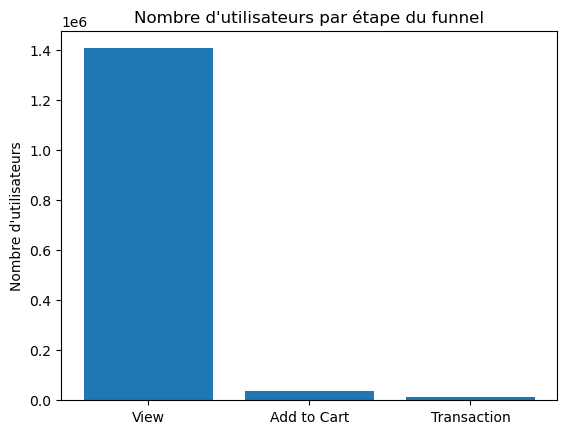

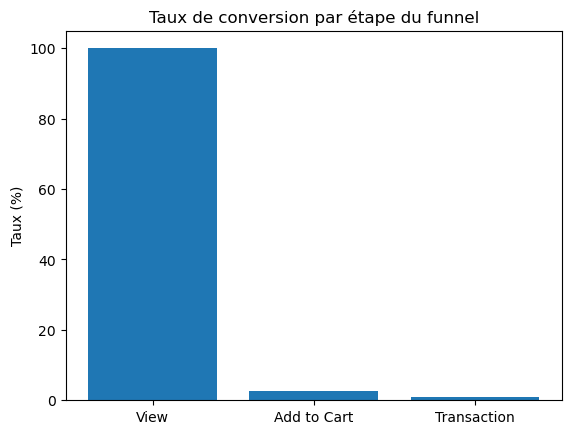

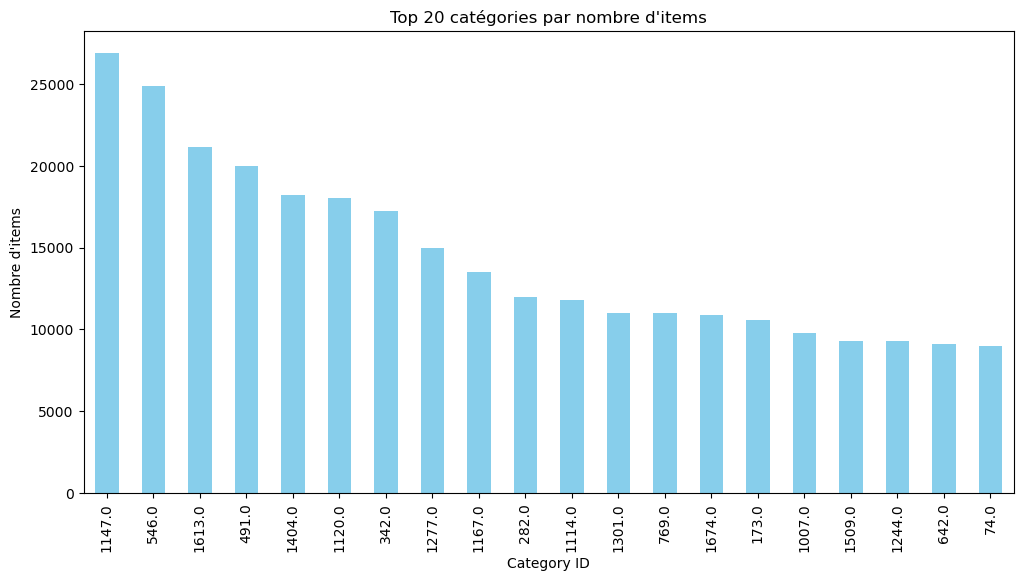

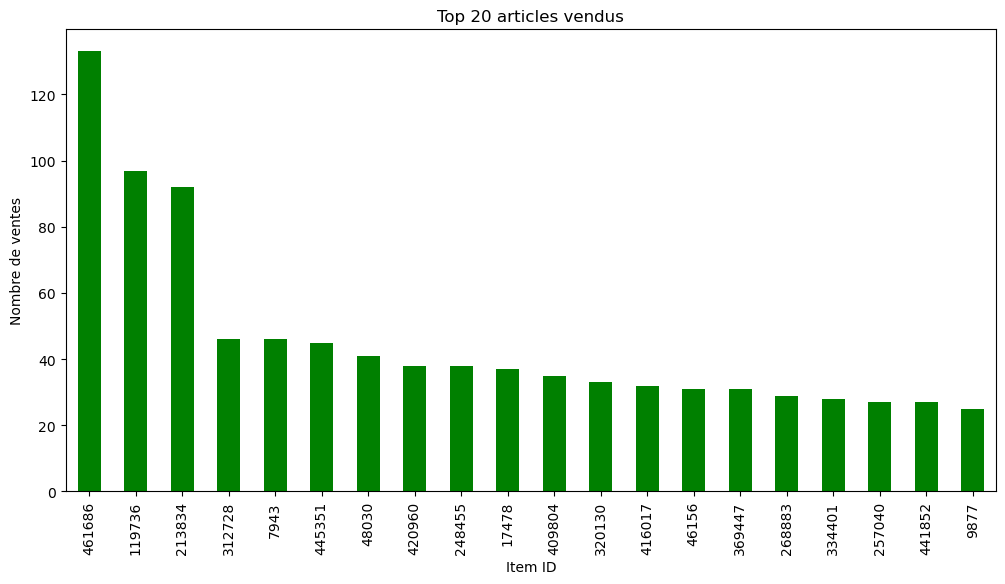

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os

# --- Config ---
os.makedirs("data/processed", exist_ok=True)
pd.options.mode.chained_assignment = None  # Pour éviter les SettingWithCopyWarning

# --- Charger les datasets ---
events = pd.read_csv("events.csv")
category_tree = pd.read_csv("category_tree.csv")
item_prop1 = pd.read_csv("item_properties_part1.csv")
item_prop2 = pd.read_csv("item_properties_part2.csv")

# Fusion des propriétés
item_properties = pd.concat([item_prop1, item_prop2], ignore_index=True)
item_properties['value'] = pd.to_numeric(item_properties['value'], errors='coerce')

# --- Exploration rapide ---
print(f"Events: {events.shape}, Category Tree: {category_tree.shape}, Item Properties: {item_properties.shape}")
print(events['event'].value_counts(normalize=True) * 100)

# --- A/B Testing sur addtocart ---
unique_visitors = events['visitorid'].unique()
np.random.shuffle(unique_visitors)
split = len(unique_visitors) // 2
group_A = unique_visitors[:split]
group_B = unique_visitors[split:]

events['group'] = np.where(events['visitorid'].isin(group_A), 'A', 'B')

# Taux addtocart par groupe
add_rates = events[events['event'] == 'addtocart'].groupby('group')['visitorid'].nunique() / \
            events.groupby('group')['visitorid'].nunique()
print(f"Taux addtocart - Groupe A : {add_rates['A']:.4f}")
print(f"Taux addtocart - Groupe B : {add_rates['B']:.4f}")

# Test z
n_A, n_B = len(group_A), len(group_B)
p_A, p_B = add_rates['A'], add_rates['B']
p_pool = (p_A*n_A + p_B*n_B) / (n_A + n_B)
z = (p_A - p_B) / np.sqrt(p_pool*(1-p_pool)*(1/n_A + 1/n_B))
p_val = 2 * (1 - stats.norm.cdf(abs(z)))
print(f"z-statistic = {z:.4f}, p-value = {p_val:.4f}")

# --- Funnel et visualisation ---
funnel_users = [
    events['visitorid'].nunique(),
    events[events['event']=='addtocart']['visitorid'].nunique(),
    events[events['event']=='transaction']['visitorid'].nunique()
]
funnel_labels = ["View", "Add to Cart", "Transaction"]
conversion_rates = [100, funnel_users[1]/funnel_users[0]*100, funnel_users[2]/funnel_users[0]*100]

# Bar charts
plt.figure()
plt.bar(funnel_labels, funnel_users)
plt.title("Nombre d'utilisateurs par étape du funnel")
plt.ylabel("Nombre d'utilisateurs")
plt.show()

plt.figure()
plt.bar(funnel_labels, conversion_rates)
plt.title("Taux de conversion par étape du funnel")
plt.ylabel("Taux (%)")
plt.show()

# --- Top catégories ---
category_counts = item_properties[item_properties['property']=='categoryid']['value'].value_counts()
plt.figure(figsize=(12,6))
category_counts.head(20).plot(kind='bar', color='skyblue')
plt.title("Top 20 catégories par nombre d'items")
plt.xlabel("Category ID")
plt.ylabel("Nombre d'items")
plt.show()

# --- Top articles vendus ---
top_items = events[events['event']=='transaction']['itemid'].value_counts().head(20)
plt.figure(figsize=(12,6))
top_items.plot(kind='bar', color='green')
plt.title("Top 20 articles vendus")
plt.xlabel("Item ID")
plt.ylabel("Nombre de ventes")
plt.show()

# --- Sauvegarde nettoyage ---
item_properties.to_csv("data/processed/category_items_clean.csv", index=False)


itemid
187946    3410
461686    2539
5411      2325
370653    1854
219512    1740
298009    1642
96924     1633
309778    1565
257040    1531
384302    1528
335975    1428
111530    1397
441668    1389
7943      1346
320130    1333
151444    1230
234255    1214
190000    1164
142466    1135
37029     1131
Name: count, dtype: int64


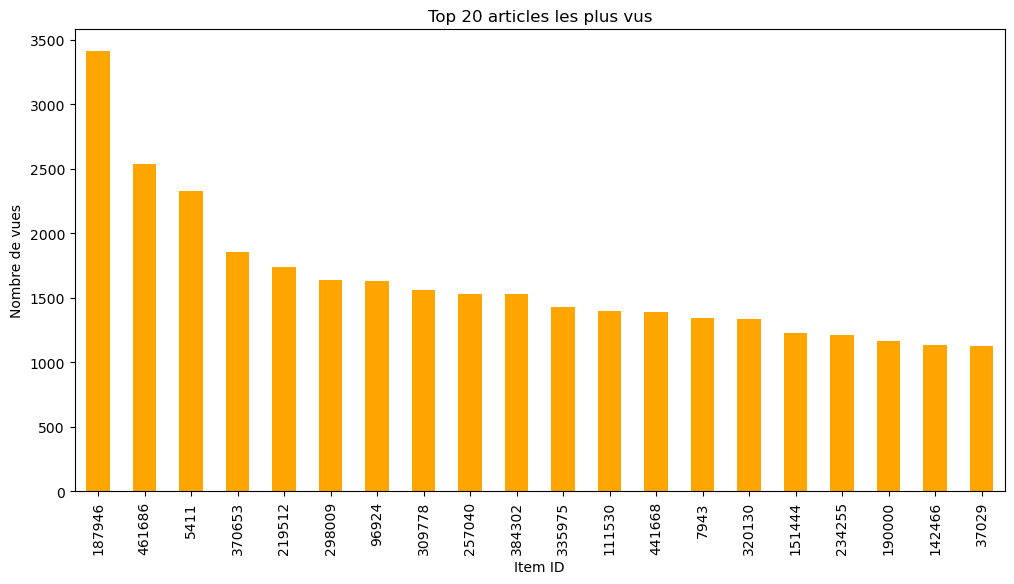

In [17]:
# Filtrer les vues
views = events[events['event'] == 'view']

# Compter le nombre de vues par article
top_viewed_items = views['itemid'].value_counts().head(20)  # Top 20 articles les plus vus

# Afficher le résultat
print(top_viewed_items)

# Optionnel : visualiser avec un graphique
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
top_viewed_items.plot(kind='bar', color='orange')
plt.title("Top 20 articles les plus vus")
plt.xlabel("Item ID")
plt.ylabel("Nombre de vues")
plt.show()

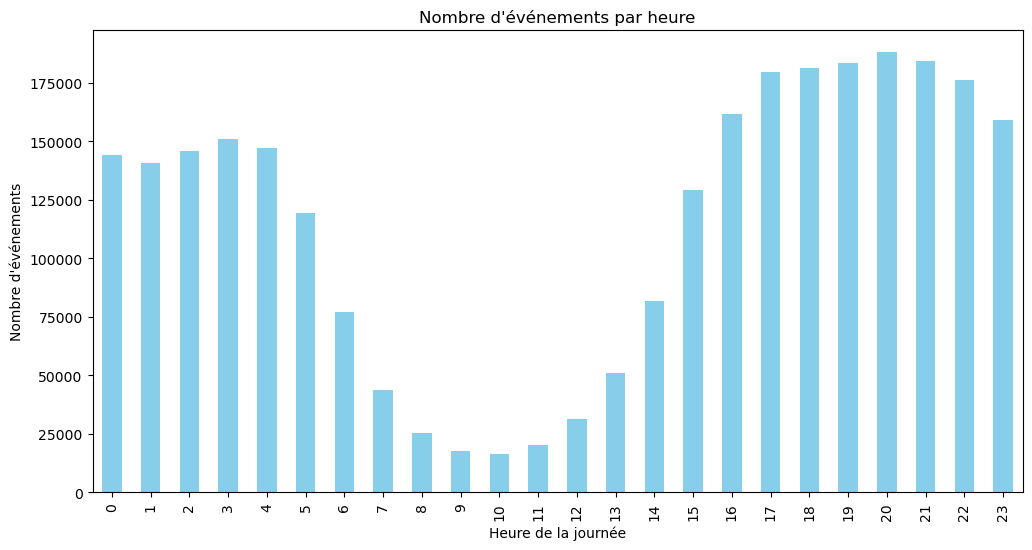

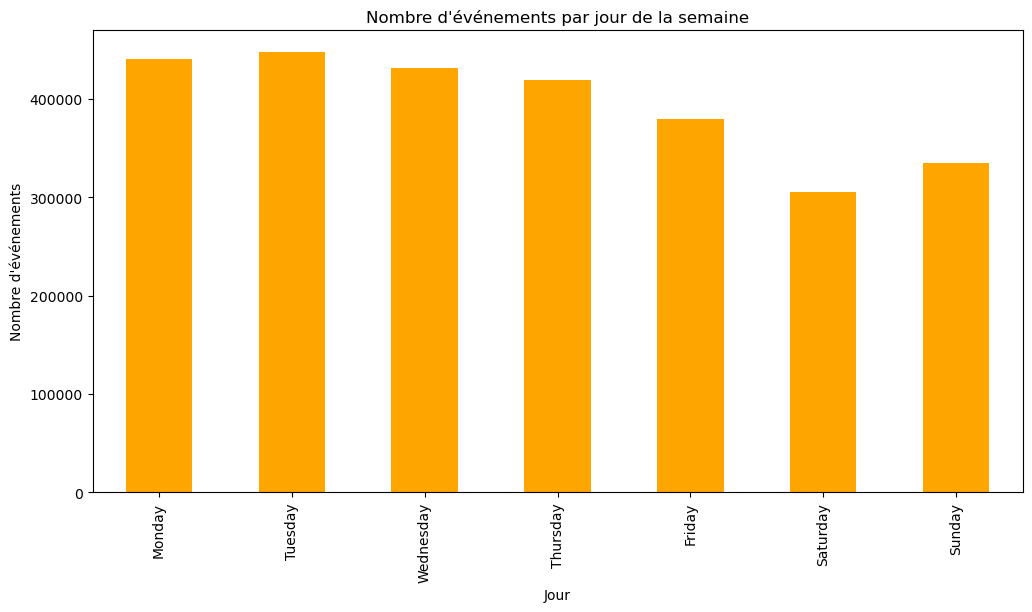

In [18]:
# Si ce n'est pas déjà fait : convertir le timestamp en datetime
events['datetime'] = pd.to_datetime(events['timestamp'], unit='ms')

# Extraire l'heure et le jour de la semaine
events['hour'] = events['datetime'].dt.hour
events['day_of_week'] = events['datetime'].dt.day_name()  # ou .dt.weekday pour 0=lundi, ..., 6=dimanche

# Nombre d'événements par heure
hourly_activity = events.groupby('hour')['event'].count()
plt.figure(figsize=(12,6))
hourly_activity.plot(kind='bar', color='skyblue')
plt.title("Nombre d'événements par heure")
plt.xlabel("Heure de la journée")
plt.ylabel("Nombre d'événements")
plt.show()

# Nombre d'événements par jour de la semaine
daily_activity = events.groupby('day_of_week')['event'].count()
# Pour que les jours soient dans l'ordre
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_activity = daily_activity.reindex(days_order)

plt.figure(figsize=(12,6))
daily_activity.plot(kind='bar', color='orange')
plt.title("Nombre d'événements par jour de la semaine")
plt.xlabel("Jour")
plt.ylabel("Nombre d'événements")
plt.show()


In [19]:
# Top 3 heures les plus actives
top_hours = hourly_activity.sort_values(ascending=False).head(3)
print("Top 3 heures les plus actives :")
print(top_hours)

# Top 3 jours les plus actifs
top_days = daily_activity.sort_values(ascending=False).head(3)
print("\nTop 3 jours les plus actifs :")
print(top_days)

Top 3 heures les plus actives :
hour
20    187919
21    184297
19    183348
Name: event, dtype: int64

Top 3 jours les plus actifs :
day_of_week
Tuesday      447077
Monday       439813
Wednesday    431114
Name: event, dtype: int64


In [20]:
# Filtrer uniquement les événements "view"
views = events[events['event'] == 'view']

# Compter le nombre de vues par itemid
view_counts = views['itemid'].value_counts()

# Article le moins vu
least_viewed_item = view_counts.idxmin()
least_viewed_count = view_counts.min()

print(f"Article le moins vu : {least_viewed_item} avec {least_viewed_count} vues")

Article le moins vu : 318923 avec 1 vues


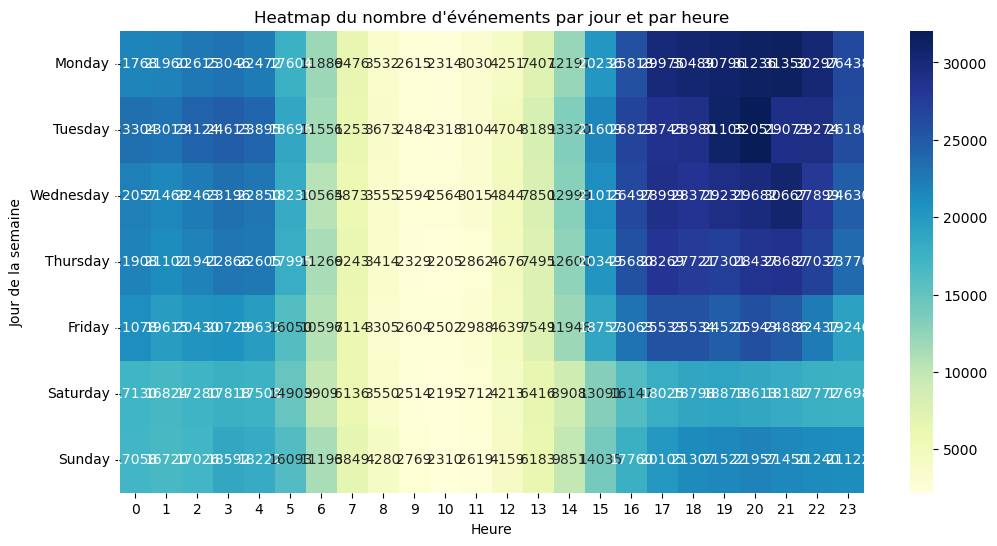

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assurez-vous d'avoir une colonne 'day_of_week' et 'hour'
events['date'] = pd.to_datetime(events['timestamp'], unit='ms')
events['hour'] = events['date'].dt.hour
events['day_of_week'] = events['date'].dt.day_name()

# Créer une matrice pivot : lignes = jours, colonnes = heures, valeurs = nombre d'événements
heatmap_data = events.pivot_table(index='day_of_week', columns='hour', values='event', aggfunc='count')

# Ordonner les jours correctement
jours_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(jours_order)

# Tracer la heatmap
plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt='d')
plt.title("Heatmap du nombre d'événements par jour et par heure")
plt.xlabel("Heure")
plt.ylabel("Jour de la semaine")
plt.show()

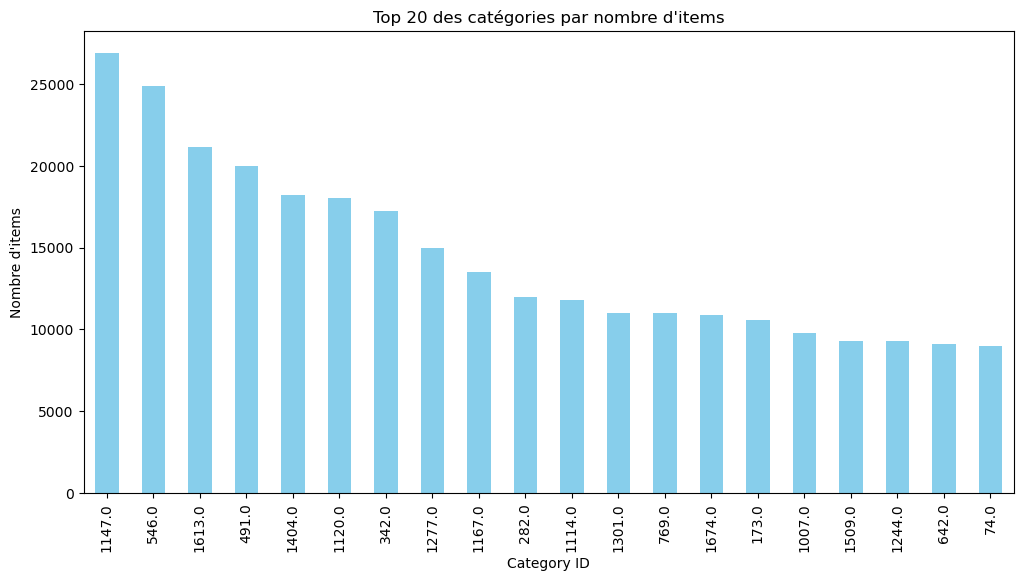

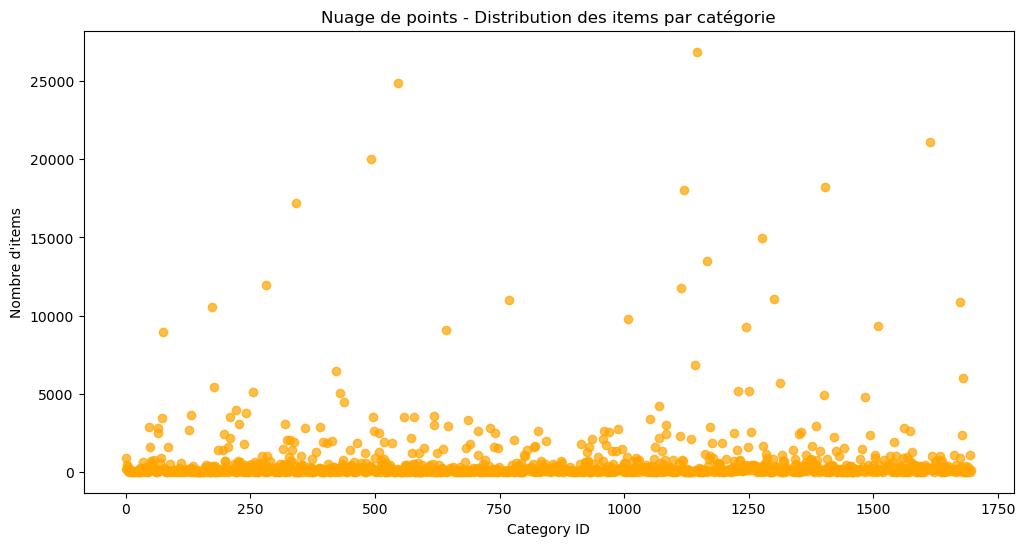

In [22]:
# Top 20 catégories
plt.figure(figsize=(12,6))
category_counts.head(20).plot(kind='bar', color='skyblue')
plt.title("Top 20 des catégories par nombre d'items")
plt.xlabel("Category ID")
plt.ylabel("Nombre d'items")
plt.show()

# Nuage de points pour toutes les catégories
plt.figure(figsize=(12,6))
plt.scatter(category_counts.index, category_counts.values, color='orange', alpha=0.7)
plt.title("Nuage de points - Distribution des items par catégorie")
plt.xlabel("Category ID")
plt.ylabel("Nombre d'items")
plt.show()


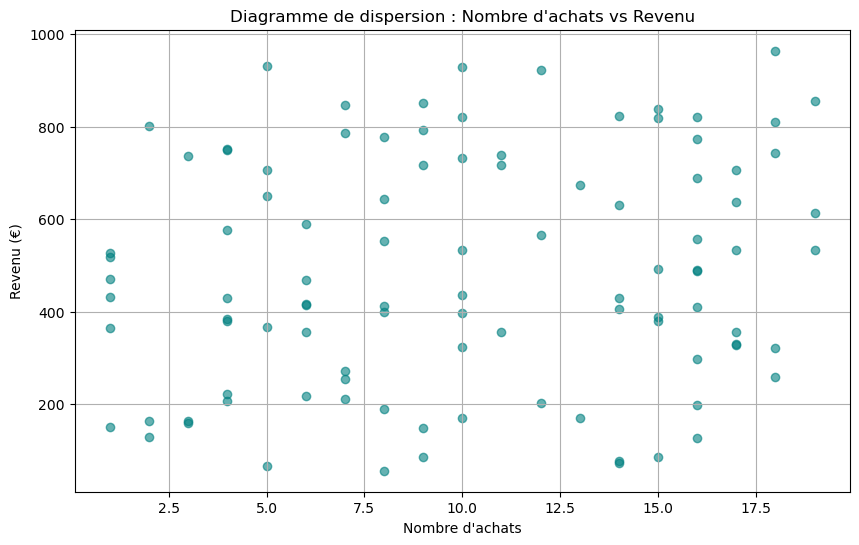

In [25]:
# Exemple de données
df = pd.DataFrame({
    'nombre_achats': np.random.randint(1, 20, size=100),
    'revenu': np.random.randint(50, 1000, size=100)
})

# Diagramme de dispersion
plt.figure(figsize=(10,6))
plt.scatter(df['nombre_achats'], df['revenu'], alpha=0.6, color='teal')
plt.title("Diagramme de dispersion : Nombre d'achats vs Revenu")
plt.xlabel("Nombre d'achats")
plt.ylabel("Revenu (€)")
plt.grid(True)
plt.show()
